In [1]:
#importing libraries
import numpy as np
from scipy.special import expit  # aka logistic
from scipy.stats import multivariate_normal
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
import os, sys
# add utilities directory to path
util_path = os.path.abspath(os.path.join(os.path.pardir, 'utilities_and_data'))
if util_path not in sys.path and os.path.exists(util_path):
    sys.path.insert(0, util_path)



In [3]:
#Seed a random state
rng = np.random.RandomState(0)

In [4]:
#data
x = np.array([-0.86, -0.30, -0.05, 0.73])
n = np.array([5, 5, 5, 5])
y = np.array([0, 1, 3, 5])

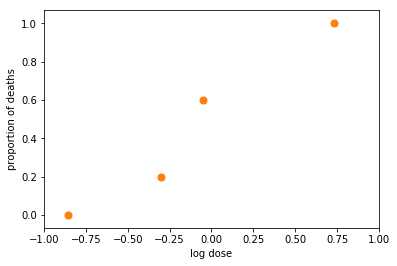

In [5]:
# plot the data
plt.scatter(x, y/n, 50, color='C1')
plt.xlim((-1, 1))
plt.xlabel('log dose')
plt.ylabel('proportion of deaths');

### Solution to 1:
Calculate the posterior density in a grid of points around the prior and plot the heatmap of the density.
$\alpha$ : 0 $\pm$ 4, $\beta$ : 10 $\pm$ 20  
 
$$ Cov =
  \begin{bmatrix}
    \sigma^2_1 & \rho\sigma_1\sigma_2  \\
    \rho\sigma_1\sigma_2 & \sigma^2_2 
  \end{bmatrix} $$
With $\sigma_1$ and $\sigma_2$ being the variances for the $\alpha$ and $\beta$ and $\rho$ being the correlation.

 Reformulating the likelihood in terms of regression parameters $\alpha$ and $\beta$
Originally, the likelihood was
$$p(y_i | \theta_i, n_i, x_i) = \binom{N}{y} \theta_i^{y_i} (1 - \theta_i)^{n_i - y_i} $$
After transforming $\theta_i$, we have
\begin{align}
p(y_i | \alpha, \beta, n_i, x_i) \propto [\text{logit}^{-1}(\alpha + \beta x_i)] ^{y_i} [1 - \text{logit}^{-1}(\alpha + \beta x_i)] ^{n_i - y_i}
\end{align}
#### To get the joint prior, 

\begin{align}
\alpha, \beta &\sim N(\mu, \Sigma) \\
              &= N\left(
                  \begin{bmatrix} \mu_\alpha \\ \mu_\beta \end{bmatrix}, 
                  \begin{bmatrix}\sigma _{\alpha}^{2}&\rho \sigma _{\alpha}\sigma _{\beta}\\\rho \sigma _{X}\sigma _{Y}&\sigma _{Y}^{2}\end{bmatrix}
              \right)
\end{align}

where $\rho$ is the correlation between $\alpha$ and $\beta$.



#### Posterior
The logistic regression model's parameters have a joint posterior distribution of
\begin{align}
p(\alpha, \beta | y, n, x) &\propto p(y | \alpha, \beta, n, x) p(\alpha, \beta | n, x) \\
                           &\propto \left( \prod_{i=1}^k p(y_i | \alpha, \beta, n_i, x_i) \right) p(\alpha, \beta)
\end{align}

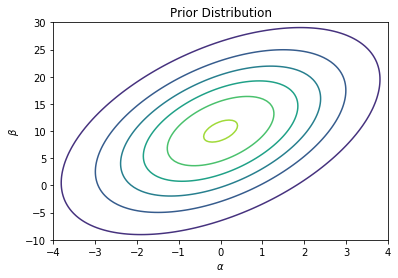

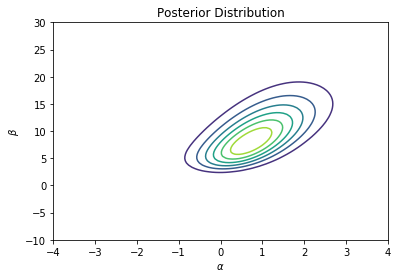

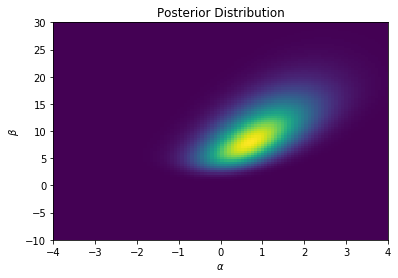

In [28]:
# compute the posterior density in grid
#  - usually should be computed in logarithms!
#  - with alternative prior, check that range and spacing of A and B
#    are sensible
#Solution to 1
A = np.linspace(-4, 4, 100)
B = np.linspace(-10, 30, 100)
ilogit_abx = 1 / (np.exp(-(A[:,None] + B[:,None,None] * x)) + 1)
likelihood = np.prod(ilogit_abx**y * (1 - ilogit_abx)**(n - y), axis=2)
#given from the data 
sig_A=2
sig_B=10
mu_A=0
mu_B=10
mean=[mu_A,mu_B]
correlation=0.5
# from wikipedia
cov_matrix=[[sig_A**2,correlation*sig_A*sig_B],[correlation*sig_A*sig_B,sig_B**2]]
prior=multivariate_normal(mean,cov_matrix)
X,Y=np.meshgrid(A,B)
g=np.array([X.flatten(),Y.flatten()]).T
prior_d=prior.pdf(g).reshape(100,100)
plt.contour(X,Y,prior_d)
plt.title("Prior Distribution")
plt.xlabel(r'$\alpha$')
plt.ylabel(r'$\beta$')
plt.show()
posterior=np.multiply(prior_d,likelihood)
plt.xlabel(r'$\alpha$')
plt.ylabel(r'$\beta$')
plt.contour(A,B,posterior)
plt.title("Posterior Distribution")
plt.show()
plt.imshow(posterior,origin='lower', aspect='auto', extent=(A[0], A[-1], B[0], B[-1]))
plt.xlabel(r'$\alpha$')
plt.ylabel(r'$\beta$')
plt.title('Posterior Distribution')
plt.show()


### Solution to 2:
We sample 5000 alpha and beta values, to get effective sample size above 1000

In [29]:
#Q2
samples=prior.rvs(5000)

### Solution 3: Compute the importance ratios for each draw

<br><br>
$$ w(\theta^s)=\frac{q(\theta^2|y)}{g(\theta^s)} $$
<br>

In [30]:
#Writing inverse logit function for pairs of alpha and beta
ilogit_abx = 1 / (1+np.exp(-(samples[:,0,None] + samples[:,1,None] * x)))

#calculate the likelihood  weights 
weights = np.prod(ilogit_abx**y * (1 - ilogit_abx)**(n - y), axis=1)

#printing just 20 as there are 5000
print(weights[:20])

[3.89133005e-04 3.48793737e-06 2.20863310e-05 2.53140598e-18
 4.56709483e-05 2.76790779e-04 1.25070845e-03 2.71078826e-10
 1.25141845e-06 3.90002771e-06 3.17060525e-07 2.08554523e-04
 1.01436600e-15 1.96519243e-09 2.51426201e-03 8.78078096e-05
 1.53454456e-05 1.28435255e-10 2.14824089e-23 3.55147225e-08]


### Solution 4: Compute the effective sample size S eff
<br><br>
$$ S_{eff} = \frac{1}{\sum_{s=1}^{S}(\tilde{w}(\theta^s))^2} $$
<br>

With $$\tilde{w}(\theta^s)=\frac{\tilde{w}(\theta^s)}{\sum_{s=1}^{S}\tilde{w}(\theta^s)}$$
The S effective value is above 1000

In [36]:
weights_norm = (weights)/np.sum(weights)
S_eff=1/np.sum(weights_norm**2)
print("The effective sample size S_eff is : ",S_eff)

The effective sample size S_eff is :  1360.4984546954834


### Solution 5: Computing posterior mean of $\alpha$ and $\beta$ using importance sampling 

In [32]:
mean_posterior = sum(weights[:,None]*samples)/sum(weights)
print("The posterior mean of alpha : ",mean_posterior[0])
print("The posterior mean of beta  : ",mean_posterior[1])

The posterior mean of alpha :  0.9765926966928049
The posterior mean of beta  :  10.583419747750634


### Solution 6: Computing posterior mean of $\alpha$ and $\beta$ using importance sampling 
The means are really close to the above means as, teh sample size is 1000 and S Eff is 1360

In [33]:
ind=rng.choice(a=5000,size=1000,replace=False,p=weights_norm)
resamples = samples[ind]

print('Mean of alpha : {0}'.format(np.mean(resamples[:,0])))
print('Mean of beta : {0}'.format(np.mean(resamples[:,1])))

Mean of alpha : 0.9723517615749074
Mean of beta : 11.016541351815544


### 7) a: Plot a scatterplot of the obtained posterior sample 
### and compare that to the heatmap plotted earlier.

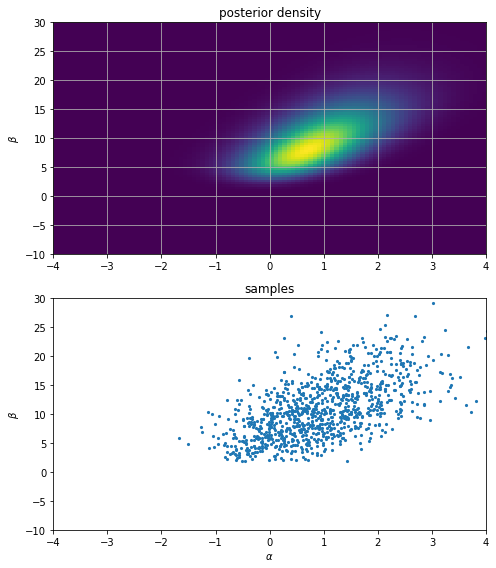

In [34]:
# create figure
fig, axes = plt.subplots(2, 1, figsize=(7, 8))

# plot the posterior density
ax = axes[0]
ax.imshow(posterior, origin='lower', aspect='auto', 
          extent=(A[0], A[-1], B[0], B[-1]))
ax.set_xlim([-4,4])
ax.set_ylim([-10,30])
ax.set_ylabel(r'$\beta$')
ax.grid(True)
ax.set_title('posterior density')

# plot the samples
ax = axes[1]
ax.scatter(resamples[:,0], resamples[:,1], 10, linewidth=0)
ax.set_xlim([-4,4])
ax.set_ylim([-10,30])
ax.set_xlabel(r'$\alpha$')
ax.set_ylabel(r'$\beta$')
ax.set_title('samples')

fig.tight_layout()

Conclusion: The posterior Density and the resample scatter are pretty similar
Due to the fact that the resample size was smaller than the S eff
Side Note: If our resample size was above 3000, they would not look the same

### 7 b) Estimate for $p(\beta > 0\mid x,n,y)$  

In [35]:
beta = resamples[:,1]
alpha = resamples[:,0]
b_pos = beta>0
prob = (beta[b_pos].size/beta.size)
print("Prob p(beta>0 | x,n,y) = {0}".format(prob))

samp_ld50 = -alpha[b_pos]/beta[b_pos]

Prob p(beta>0 | x,n,y) = 1.0


###  7 c) histogram of the draws from the posterior distribution of the LD50 conditional
### on $\beta$ > 0

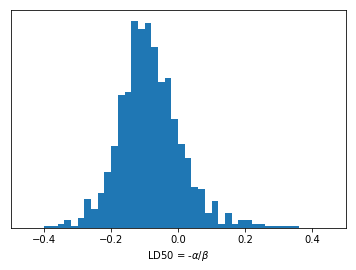

In [26]:
# plot the histogram of LD50
plt.hist(samp_ld50, np.arange(-0.5, 0.51, 0.02))
plt.xlim([-0.5, 0.5])
plt.xlabel(r'LD50 = -$\alpha/\beta$')
plt.yticks(());